# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [35]:
import io
import os
import numpy as np
import scipy
from math import *
from utils import *
from tqdm import tqdm
from scipy.linalg import svd
from sklearn import linear_model

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

In [5]:
PATH_TO_DATA = os.getcwd() + "/data/"

# 1) Monolingual (English) word embeddings 

In [7]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.word2id = {k: i for i, k in enumerate(self.word2vec.keys())}
        #dict.fromkeys(self.word2vec.keys(), np.arange(1, len(self.word2vec.keys())))
        self.id2word = {v: k for k, v in self.word2id.items()}
        self.embeddings = np.array(list(self.word2vec.values()))
        
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ')
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort 
        scores = [self.score(w, k) for k in self.word2vec.keys()]
        return list(reversed([self.id2word[i] for i in np.argsort(scores)[-(K+1):-1]]))

    def score(self, w1, w2):
        v1, v2 = self.word2vec[w1], self.word2vec[w2]
        # cosine similarity: np.dot  -  np.linalg.norm
        return v1.dot(v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))


In [8]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=100000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))

Loaded 100000 pretrained word vectors
cat dog 0.671683666279249
dog pet 0.6842064029669219
dogs cats 0.7074389328052404
paris france 0.7775108541288563
germany berlin 0.7420295235998394
['cats', 'kitty', 'kitten', 'feline', 'kitties']
['dogs', 'puppy', 'Dog', 'doggie', 'canine']
['dog', 'pooches', 'Dogs', 'doggies', 'canines']
['france', 'Paris', 'london', 'berlin', 'tokyo']
['austria', 'europe', 'german', 'berlin', 'poland']


In [9]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        sentemb = []
        for sent in sentences:
            embeddings = np.array([w2v.word2vec[s] for s in sent.split(' ') if (s in self.w2v.word2vec.keys())])
            if idf is False:
                # mean of word vectors
                sentemb.append(np.mean(embeddings, axis=0))
            else:
                # idf-weighted mean of word vectors
                weights = [idf[w] for w in sent.split(' ') if (w in self.w2v.word2vec.keys())]
                sentemb.append(np.average(embeddings, axis=0, weights = weights))
                #assert False, 'TODO: fill in the blank'
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        keys = self.encode(sentences, idf)
        query = self.encode([s], idf).reshape(300)
        scores = np.argsort([self.score(k, query, emb=True) for k in keys])
        top_sent_index = scores[-(K+1):-1]
        top_sent = [sentences[i] for i in top_sent_index]
        print("Top {} most similar sentences to '{}' :".format(K, s))
        for sent in reversed(top_sent):
            print("- ", sent) 
    
    def score(self, s1, s2, idf=False, emb = False):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        if emb:
            return s1.dot(s2)/(np.linalg.norm(s1)*np.linalg.norm(s2))
        else:
            embeds = self.encode([s1, s2], idf = idf)
            v1, v2 = embeds[0], embeds[1]
            return v1.dot(v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        D = len(sentences)
        idf = {}
        
        for sent in sentences:
            for w in set(sent.split(' ')):
                idf[w] = idf.get(w, 0) + 1
        for word in idf.keys():
            idf[word] = max(1, np.log10(len(sentences) / (idf[word])))

        return idf

In [10]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=100000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
sentences = []
with open(os.path.join(PATH_TO_DATA, "sentences.txt"), "r") as f:
    sentences = f.read().splitlines()

# Build idf scores for each word
idf = s2v.build_idf(sentences)

# You will be evaluated on the output of the following:
s2v.most_similar('' if not sentences else sentences[10], sentences)  # BoV-mean
#s2v.score(sentences[7], sentences[13])
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13]))

idf = s2v.build_idf(sentences)  
s2v.most_similar('' if not sentences else sentences[10], sentences, idf)  # BoV-idf
print(s2v.score('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf))

Loaded 100000 pretrained word vectors
Top 5 most similar sentences to '1 smiling african american boy . ' :
-  an african american man smiling . 
-  a little african american boy and girl looking up . 
-  an afican american woman standing behind two small african american children . 
-  an african american man is sitting . 
-  a girl in black hat holding an african american baby . 
0.5726258859719605
Top 5 most similar sentences to '1 smiling african american boy . ' :
-  an african american man smiling . 
-  an african american man is sitting . 
-  a little african american boy and girl looking up . 
-  an afican american woman standing behind two small african american children . 
-  a girl in black hat holding an african american baby . 
0.47514508753687823


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X** and **Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W\* = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [54]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec
w2v_wiki_fr = Word2vec(os.path.join(PATH_TO_DATA, "wiki.fr.vec"), nmax=50000)
w2v_wiki_en = Word2vec(os.path.join(PATH_TO_DATA, "wiki.en.vec"), nmax=50000)

wiki_fr = w2v_wiki_fr.word2vec
wiki_en = w2v_wiki_en.word2vec

In [78]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

set_en, set_fr = set(wiki_en.keys()), set(wiki_fr.keys())

common_words = set_en.intersection(set_fr)

X, Y = [], []

for w in common_words:
    X.append(wiki_fr[w])
    Y.append(wiki_en[w])
X = np.array(X).T
Y = np.array(Y).T

In [126]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

U, sigma, V = svd(Y.dot(X.T))
W = U.dot(V)

In [131]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

french_words = ['chat', 'chien', 'partir', 'profond', 'apprentissage']
english_words = ['cat', 'dog', 'leave', 'deep', 'learning']

def top_k_closest(v1, emb_dict, k = 5):
    top = []
    for w in emb_dict.keys():
        v2 = emb_dict[w]
        top.append(v1.dot(v2)/(np.linalg.norm(v1)*np.linalg.norm(v2)))
    index_top = np.argsort(top)[-k:]
    return [list(emb_dict.keys())[i] for i in index_top]

for w_fr in french_words:
    nn = top_k_closest(W.dot(wiki_fr[w_fr]), wiki_en, k=5)
    print("English nearest neighbors of '{}': {}".format(w_fr, ', '.join(nn)))
print("==========================")    
for w_en in english_words:
    nn = top_k_closest(W.T.dot(wiki_en[w_en]), wiki_fr, k=5)
    print("French nearest neighbors of '{}': {}".format(w_en, ', '.join(nn)))

English nearest neighbors of 'chat': poodle, feline, hamster, rabbit, cat
English nearest neighbors of 'chien': spaniel, dogs, terrier, poodle, dog
English nearest neighbors of 'partir': reconstituted, beginning, until, onward, onwards
English nearest neighbors of 'profond': shallow, shallower, deepest, deeper, deep
English nearest neighbors of 'apprentissage': skills, learners, learning, learner, apprenticeship
French nearest neighbors of 'cat': chien, chats, dog, chat, cat
French nearest neighbors of 'dog': chienne, chiens, hound, chien, dog
French nearest neighbors of 'leave': revienne, quitte, give, this, leave
French nearest neighbors of 'deep': profondes, profonde, profondeurs, profond, deep
French nearest neighbors of 'learning': educational, apprentissages, apprentissage, education, learning


If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [12]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

# Load train data
with open(os.path.join(PATH_TO_DATA, "SST/stsa.fine.train"), "r") as f:
    train_data = np.array(f.read().splitlines())   
X_train, Y_train = [], []
for t in train_data:
    X_train.append(t[2:])
    Y_train.append(int(t[0]))
del train_data
    
# Load test data
with open(os.path.join(PATH_TO_DATA, "SST/stsa.fine.test.X"), "r") as f:
    X_test = np.array(f.read().splitlines())

# Load validation data
with open(os.path.join(PATH_TO_DATA, "SST/stsa.fine.dev"), "r") as f:
    dev_data = np.array(f.read().splitlines())
X_dev, Y_dev = [], []
for t in dev_data:
    X_dev.append(t[2:])
    Y_dev.append(int(t[0]))
del dev_data

In [13]:
# 2 - Encode sentences with the BoV model above

# Here we encode the sentence using the simple average of the BoV embeddings, which yields better results than the weighted-average one.
# The results in the case of a weighted average can be found in the appendix of this notebook
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=200000)
s2v = BoV(w2v)

# Compute the weights by using the full dataset and the sentences of section 1
idf = s2v.build_idf(sentences = sentences + X_train + X_dev + list(X_test))

X_train_emb = s2v.encode(X_train)
X_dev_emb = s2v.encode(X_dev)
X_test_emb = s2v.encode(X_test)

Loaded 200000 pretrained word vectors


100%|██████████| 20/20 [00:49<00:00,  4.26s/it]


Best regularization parameter on validation set : 3.36
Accuracy on train set:  0.511938202247191
Accuracy on validation set:  0.44504995458673935


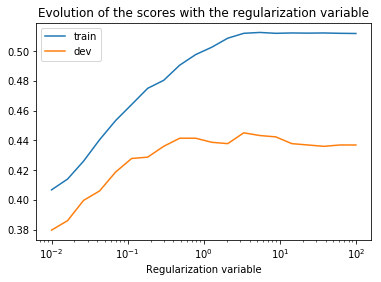

In [14]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

# Search for the optimal regularization strengh
reg = np.logspace(-2, 2, 20)
score_train = []
score_dev = []
for r in tqdm(reg):
    Logreg = linear_model.LogisticRegression(penalty='l2', C=r, solver='newton-cg', multi_class='multinomial')
    Logreg = Logreg.fit(X_train_emb, Y_train)
    score_train.append(Logreg.score(X_train_emb, Y_train))
    score_dev.append(Logreg.score(X_dev_emb, Y_dev))
print("Best regularization parameter on validation set : {}".format(round(reg[np.argsort(score_dev)[-1]], 2)))

# Evolution of the scores with the regularization variable
plt.figure()
plt.title("Evolution of the scores with the regularization variable")
plt.plot(reg, score_train, label='train')
plt.plot(reg, score_dev, label='dev')
plt.legend()
plt.xscale('log')
plt.xlabel("Regularization variable")
plt.plot()

# Run the model with the optimal regularization parameter
opt_C = reg[np.argsort(score_dev)[-1]]
Logreg = linear_model.LogisticRegression(penalty='l2', C=opt_C, solver='newton-cg', multi_class='multinomial')
Logreg = Logreg.fit(X_train_emb, Y_train)

print("Accuracy on train set: ", Logreg.score(X_train_emb, Y_train))
print("Accuracy on validation set: ", Logreg.score(X_dev_emb, Y_dev))

In [15]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

test_predictions = Logreg.predict(X_test_emb)

with open(PATH_TO_DATA + "export/logreg_bov_y_test_sst.txt", "w+") as f:
    for line in test_predictions:
        f.write(str(line) + "\n")   

# Bonus

In [16]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

## Random Forest Classifier

In [17]:
# Using a Random Forest classifier
from sklearn.ensemble import RandomForestClassifier

# Parameters
n_trees = 50
max_depth = 6

RF = RandomForestClassifier(random_state=10, n_estimators=n_trees, class_weight = "balanced", max_depth=max_depth, bootstrap=False)

RF = RF.fit(X_train_emb, Y_train)

print("Random forest classifier accuracy on train set: ", RF.score(X_train_emb, Y_train))
print("Random forest classifier accuracy on validation set: ", RF.score(X_dev_emb, Y_dev))

Random forest classifier accuracy on train set:  0.5617977528089888
Random forest classifier accuracy on validation set:  0.36239782016348776


## MLP

In [18]:
# Using a MLP
from sklearn.neural_network import MLPClassifier

# Parameters
r = 1e-1
size = (12,)

mlp = MLPClassifier(random_state=10, solver='lbfgs', alpha=r, hidden_layer_sizes=size)
mlp.fit(X_train_emb, Y_train)

print("MLP accuracy on train set: ", mlp.score(X_train_emb, Y_train))
print("MLP accuracy on validation set: ", mlp.score(X_dev_emb, Y_dev))

test_predictions_mlp = mlp.predict(X_test_emb)

with open(PATH_TO_DATA + "export/mlp_bov_y_test_sst.txt", "w+") as f:
    for line in test_predictions_mlp:
        f.write(str(line) + "\n")   

MLP accuracy on train set:  0.5321863295880149
MLP accuracy on validation set:  0.4223433242506812


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [29]:
import keras
from keras.layers import Embedding, Dense, InputLayer, Bidirectional, LSTM
from keras.models import Sequential

In [20]:
# 1 - Load train/dev/test sets of SST

with open(os.path.join(PATH_TO_DATA, "SST/stsa.fine.train"), "r") as f:
    train_data = np.array(f.read().splitlines())   
X_train, Y_train = [], []
for t in train_data:
    X_train.append(t[2:])
    Y_train.append(int(t[0]))
del train_data
    
with open(os.path.join(PATH_TO_DATA, "SST/stsa.fine.test.X"), "r") as f:
    X_test = f.read().splitlines()

with open(os.path.join(PATH_TO_DATA, "SST/stsa.fine.dev"), "r") as f:
    dev_data = np.array(f.read().splitlines())
X_dev, Y_dev = [], []
for t in dev_data:
    X_dev.append(t[2:])
    Y_dev.append(int(t[0]))
del dev_data

In [21]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

def flatten(l):
    return [item for sublist in l for item in sublist.split(' ')]

# Get the length of the vocabulary of the train set
vocab_len = len(set(flatten(X_train)))

X_train_oh = []
for sent in X_train:
    X_train_oh.append(keras.preprocessing.text.one_hot(sent, vocab_len))

X_dev_oh = []
for sent in X_dev:
    X_dev_oh.append(keras.preprocessing.text.one_hot(sent, vocab_len))

X_test_oh = []
for sent in X_test:
    X_test_oh.append(keras.preprocessing.text.one_hot(sent, vocab_len))

**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [22]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

max_length = max([len(sent) for sent in X_train_oh+X_dev_oh+X_test_oh])

X_train_work = keras.preprocessing.sequence.pad_sequences(X_train_oh, maxlen=max_length)
Y_train_work = keras.preprocessing.utils.to_categorical(Y_train)

X_dev_work = keras.preprocessing.sequence.pad_sequences(X_dev_oh, maxlen=max_length)
Y_dev_work = keras.preprocessing.utils.to_categorical(Y_dev)

X_test_work = keras.preprocessing.sequence.pad_sequences(X_test_oh, maxlen=max_length)

## 4.2 - Design and train your model

In [30]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.

# Parameters
embed_dim  = 10  # word embedding dimension
nhid       = 8 # number of hidden units in the LSTM
vocab_size = len(set(flatten(X_train)))  # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim))
model.add(LSTM(nhid, dropout=0.5, recurrent_dropout=0.5))
model.add(Dense(n_classes, activation='sigmoid'))

In [31]:
# 5 - Define your loss/optimizer/metrics

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  keras.optimizers.Adam(5e-3) # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif,
                )
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 10)          165810    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 608       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 45        
Total params: 166,463
Trainable params: 166,463
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

bs = 32
n_epochs = 5

history = model.fit(X_train_work, Y_train_work, batch_size=bs, 
                    epochs=n_epochs, validation_data=(X_dev_work, Y_dev_work))

Train on 8544 samples, validate on 1101 samples
Epoch 1/5
8544/8544 [==============================] - 15s 2ms/step - loss: 1.5706 - acc: 0.2731 - val_loss: 1.5573 - val_acc: 0.2861
Epoch 2/5
8544/8544 [==============================] - 14s 2ms/step - loss: 1.4497 - acc: 0.3669 - val_loss: 1.4485 - val_acc: 0.3633
Epoch 3/5
8544/8544 [==============================] - 14s 2ms/step - loss: 1.2558 - acc: 0.4737 - val_loss: 1.4791 - val_acc: 0.3715
Epoch 4/5
8544/8544 [==============================] - 14s 2ms/step - loss: 1.0941 - acc: 0.5616 - val_loss: 1.5476 - val_acc: 0.3697
Epoch 5/5
8544/8544 [==============================] - 14s 2ms/step - loss: 0.9781 - acc: 0.6127 - val_loss: 1.6006 - val_acc: 0.3742


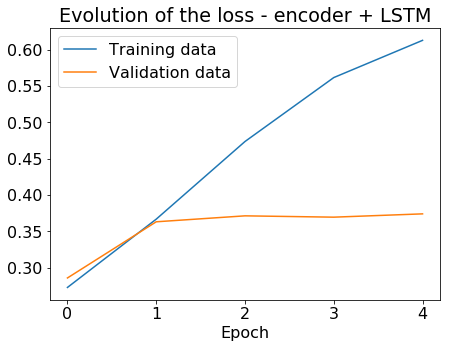

In [36]:
plot_history(history, metric = 'acc', title='Evolution of the loss - encoder + LSTM')
#plt.savefig("figures/encoder_LSTM_train_dev.png")

In [37]:
train_acc = model.evaluate(X_train_work, Y_train_work)[1]
dev_acc = model.evaluate(X_dev_work, Y_dev_work)[1]
print("Encoder + LSTM accuracy on train set: ", train_acc)
print("Encoder + LSTM accuracy on validation set: ", dev_acc)

1101/1101 [==============================] - 0s 308us/step
Encoder + LSTM accuracy on train set:  0.7597144194756554
Encoder + LSTM accuracy on validation set:  0.374205268005909


In [38]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

test_predictions = model.predict_classes(X_test_work)

with open(PATH_TO_DATA + "export/logreg_lstm_y_test_sst.txt", "w+") as f:
    for line in test_predictions:
        f.write(str(line) + "\n")   

## 4.3 -- innovate !

In [39]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# The idea is to use the word embeddings from word2vec, instead of learning them in the network
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=200000)

def vectorize_data(data, w2v):
    vec = []
    for x in data:
    #    X_train_w2v.append(keras.preprocessing.sequence.pad_sequences(
    #        [w2v.word2vec[w] for w in x.split(' ') if (w in w2v.word2vec.keys())],
    #                                                                  maxlen=max_length)
        vec.append([w2v.word2vec[w] for w in x.split(' ') if (w in w2v.word2vec.keys())])
    return vec

def pad_embed(vec, max_length, dim=300):
    output = vec
    zero_embed = np.array([0]*dim)
    for x in output:
        x+= [zero_embed]*(max_length - len(x))
    return np.array(output)


max_length = max([len(sent.split(' ')) for sent in X_train+X_dev+X_test])

X_train_emb = pad_embed(vectorize_data(X_train, w2v), max_length)
Y_train_work = keras.preprocessing.utils.to_categorical(Y_train)

X_dev_emb = pad_embed(vectorize_data(X_dev, w2v), max_length)
Y_dev_work = keras.preprocessing.utils.to_categorical(Y_dev)

X_test_emb = pad_embed(vectorize_data(X_test, w2v), max_length)

Loaded 200000 pretrained word vectors


In [45]:
# Model architecture

# Parameters
embed_dim  = 300
nhid       = 64  # number of hidden units in the LSTM
n_classes  = 5

model = Sequential()
model.add(InputLayer((max_length, embed_dim)))
model.add(Bidirectional(LSTM(nhid, dropout=0.5, recurrent_dropout=0.5)))
model.add(Dense(n_classes, activation='softmax'))

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  keras.optimizers.Adam(1e-2) # find the right optimizer
metrics_classif  =  ['accuracy']

# We use a learning rate scheduler to decrease the learning rate every 3 epochs
def lr_schedule(x, current_lr):
    if x%3==0:
        return current_lr/2
    else:
        return current_lr
    
lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)

# We also set a model checkpoint to retreive the best optimal weights of the training phase
cp_callback = keras.callbacks.ModelCheckpoint("models/optimal_weights.hdf5", 
                                monitor='val_acc', 
                                save_best_only=True)


model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_2 (Bidirection (None, 128)               186880    
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 187,525
Trainable params: 187,525
Non-trainable params: 0
_________________________________________________________________
None


In [46]:
bs = 64
n_epochs = 9

history = model.fit(X_train_emb, Y_train_work, batch_size=bs, 
                    epochs=n_epochs, validation_data=(X_dev_emb, Y_dev_work), callbacks = [lr_callback, cp_callback])

Train on 8544 samples, validate on 1101 samples
Epoch 1/9

Epoch 00001: LearningRateScheduler setting learning rate to 0.004999999888241291.
8544/8544 [==============================] - 23s 3ms/step - loss: 1.4293 - acc: 0.3612 - val_loss: 1.3100 - val_acc: 0.4214
Epoch 2/9

Epoch 00002: LearningRateScheduler setting learning rate to 0.004999999888241291.
8544/8544 [==============================] - 19s 2ms/step - loss: 1.3046 - acc: 0.4280 - val_loss: 1.2609 - val_acc: 0.4332
Epoch 3/9

Epoch 00003: LearningRateScheduler setting learning rate to 0.004999999888241291.
8544/8544 [==============================] - 22s 3ms/step - loss: 1.2604 - acc: 0.4431 - val_loss: 1.2471 - val_acc: 0.4578
Epoch 4/9

Epoch 00004: LearningRateScheduler setting learning rate to 0.0024999999441206455.
8544/8544 [==============================] - 21s 2ms/step - loss: 1.2215 - acc: 0.4709 - val_loss: 1.2348 - val_acc: 0.4569
Epoch 5/9

Epoch 00005: LearningRateScheduler setting learning rate to 0.0024999999

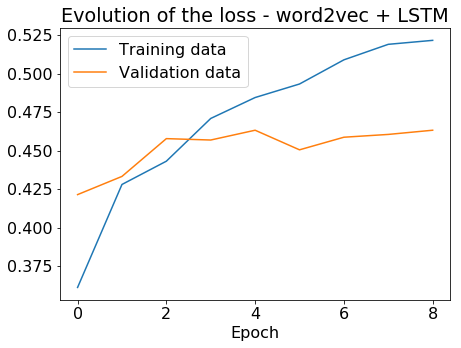

In [49]:
plot_history(history, metric='acc', title='Evolution of the loss - word2vec + LSTM')
#plt.savefig("figures/w2v_LSTM_train_dev.png")

In [47]:
model.load_weights("models/optimal_weights.hdf5")

train_acc = model.evaluate(X_train_emb, Y_train_work)[1]
dev_acc = model.evaluate(X_dev_emb, Y_dev_work)[1]
print("Encoder + LSTM accuracy on train set: ", train_acc)
print("Encoder + LSTM accuracy on validation set: ", dev_acc)

1101/1101 [==============================] - 1s 1ms/step
Encoder + LSTM accuracy on train set:  0.5396769662921348
Encoder + LSTM accuracy on validation set:  0.46321525893679105


In [50]:
test_predictions_w2v_lstm = model.predict_classes(X_test_emb)

with open(PATH_TO_DATA + "export/w2v_lstm_y_test_sst.txt", "w+") as f:
    for line in test_predictions_w2v_lstm:
        f.write(str(line) + "\n")   

# -- Appendix --

## Sentence classification with BoV 

### Classification using weigthed average

In [53]:
# 2 - Encode sentences with the BoV model above

# Here we encode the sentence using the simple average of the BoV embeddings, which yields better results than the weighted-average one.
# The results in the case of a weighted average can be found in the appendix of this notebook
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=200000)
s2v = BoV(w2v)

# Compute the weights by using the training dataset and the sentences of section 1
idf = s2v.build_idf(sentences = sentences + X_train + X_dev + X_test)

X_train_emb = s2v.encode(X_train, idf)
X_dev_emb = s2v.encode(X_dev, idf)
X_test_emb = s2v.encode(X_test, idf)

Loaded 200000 pretrained word vectors


100%|██████████| 20/20 [00:53<00:00,  4.43s/it]


Best regularization parameter on validation set : 0.07
Accuracy on train set:  0.4675795880149813
Accuracy on validation set:  0.43505903723887374


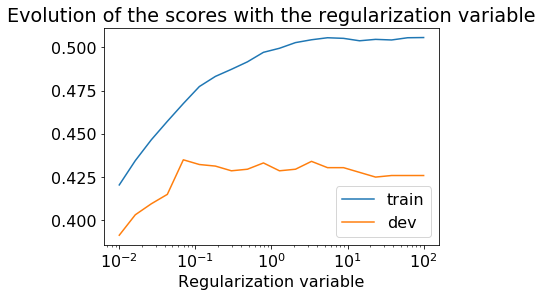

In [54]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

# Search for the optimal regularization strengh
reg = np.logspace(-2, 2, 20)
score_train = []
score_dev = []
for r in tqdm(reg):
    Logreg = linear_model.LogisticRegression(penalty='l2', C=r, solver='newton-cg', multi_class='multinomial')
    Logreg = Logreg.fit(X_train_emb, Y_train)
    score_train.append(Logreg.score(X_train_emb, Y_train))
    score_dev.append(Logreg.score(X_dev_emb, Y_dev))
print("Best regularization parameter on validation set : {}".format(round(reg[np.argsort(score_dev)[-1]], 2)))

# Evolution of the scores with the regularization variable
plt.figure()
plt.title("Evolution of the scores with the regularization variable")
plt.plot(reg, score_train, label='train')
plt.plot(reg, score_dev, label='dev')
plt.legend()
plt.xscale('log')
plt.xlabel("Regularization variable")
plt.plot()

# Run the model with the optimal regularization parameter
opt_C = reg[np.argsort(score_dev)[-1]]
Logreg = linear_model.LogisticRegression(penalty='l2', C=opt_C, solver='newton-cg', multi_class='multinomial')
Logreg = Logreg.fit(X_train_emb, Y_train)

print("Accuracy on train set: ", Logreg.score(X_train_emb, Y_train))
print("Accuracy on validation set: ", Logreg.score(X_dev_emb, Y_dev))

### Parameter search for MLP classifier

In [368]:
# Regularization strengh
reg = np.logspace(-4, 2, 10)
score_train = []
score_dev = []
for r in tqdm(reg):
    mlp = MLPClassifier(solver='lbfgs', alpha=r, hidden_layer_sizes=10, random_state=1)
    mlp.fit(X_train_emb, Y_train)
    score_train.append(mlp.score(X_train_emb, Y_train))
    score_dev.append(mlp.score(X_dev_emb, Y_dev))

100%|██████████| 10/10 [00:38<00:00,  3.31s/it]


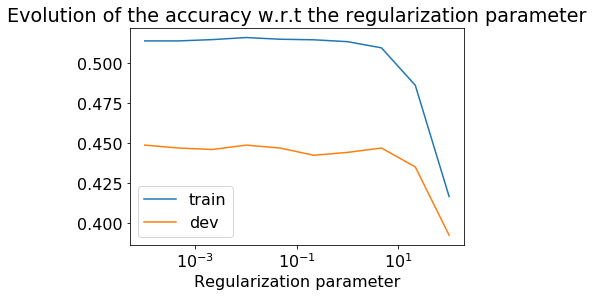

In [369]:
plt.figure()
plt.title("Evolution of the accuracy w.r.t the regularization parameter")
plt.plot(reg, score_train, label='train')
plt.plot(reg, score_dev, label='dev')
plt.xlabel('Regularization parameter')
plt.legend()
plt.xscale('log')

In [370]:
r = 0.1

# Size of the layer
sizes = np.linspace(2, 15, 10)
score_train = []
score_dev = []
for s in tqdm(sizes):
    mlp = MLPClassifier(solver='lbfgs', alpha=r, hidden_layer_sizes=(int(s),), random_state=1)
    mlp.fit(X_train_emb, Y_train)
    score_train.append(mlp.score(X_train_emb, Y_train))
    score_dev.append(mlp.score(X_dev_emb, Y_dev))

100%|██████████| 10/10 [00:34<00:00,  3.73s/it]


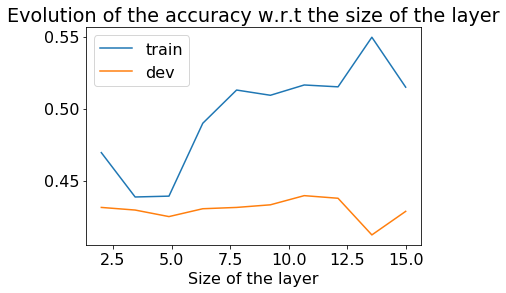

In [371]:
plt.figure()
plt.title("Evolution of the accuracy w.r.t the size of the layer")
plt.plot(sizes, score_train, label='train')
plt.plot(sizes, score_dev, label='dev')
plt.xlabel('Size of the layer')
plt.legend()